# DQN für LunarLander-v2 

# Dieses Notebook implementiert einen Deep Q-Learning-Agenten für die Umgebung `LunarLander-v2` aus OpenAI Gym.


In [ ]:
#Importieren und einen seed verwenden
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import gym

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


In [38]:
# Deep Q-Network (DQN): Das neuronale Netz, das für jede State-Action-Paarung einen Q-Wert lernt
# Es besteht aus zwei versteckten Schichten mit jeweils 128 Neuronen und verwendet ReLU-Aktivierung

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, action_dim)  # Ausgabe: Q-Werte für jede Aktion

    def forward(self, x):
        x = F.relu(self.fc1(x))               # Erste ReLU-Aktivierung
        x = F.relu(self.fc2(x))               # Zweite ReLU-Aktivierung
        return self.out(x)                    # Ausgabe der Q-Werte für den gegebenen Zustand


In [39]:
# ReplayBuffer: Speichert vergangene Übergänge (Transitions), um Korrelationen im Training zu vermeiden
# Stichwort: Experience Replay

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)  # Puffergröße begrenzt

    def push(self, transition):
        self.buffer.append(transition)        # Neue Transition speichern (state, action, reward, next_state, done)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)  # Zufällige Auswahl von Transitions
        state, action, reward, next_state, done = map(np.array, zip(*batch))  # Entpacken
        return (
            torch.FloatTensor(state),
            torch.LongTensor(action),
            torch.FloatTensor(reward),
            torch.FloatTensor(next_state),
            torch.FloatTensor(done)
        )

    def __len__(self):
        return len(self.buffer)               # Gibt an, wie viele Elemente aktuell im Puffer sind


In [ ]:
# Initialisierung: Hyperparameter, Umgebung, Netzwerke, Optimierer und Replay Buffer

ENV_NAME = "LunarLander-v2"
EPISODES = 1000           # Anzahl der Trainings-Episoden
GAMMA = 0.99              # Diskontfaktor
LR = 1e-3                 # Lernrate
BATCH_SIZE = 64
BUFFER_SIZE = 10000       # Replay-Buffer-Größe
TARGET_UPDATE = 10        # Wie oft wird das Zielnetz aktualisiert
EPS_START = 1.0           # Startwert für Epsilon (Exploration)
EPS_END = 0.01            # Minimaler Epsilon-Wert
EPS_DECAY = 0.995         # Abnahmefaktor für Epsilon pro Episode

# Umgebung starten
env = gym.make(ENV_NAME)
env.reset(seed=SEED)
state_dim = env.observation_space.shape[0]  # Anzahl Beobachtungswerte
action_dim = env.action_space.n            # Anzahl möglicher Aktionen

# Netzwerke initialisieren (Policy + Target)
policy_net = DQN(state_dim, action_dim)
target_net = DQN(state_dim, action_dim)
target_net.load_state_dict(policy_net.state_dict())  # Targetnetz = Kopie
target_net.eval()  # Target-Netz nur im Evaluierungsmodus

# Optimierer und Replay-Buffer
optimizer = torch.optim.Adam(policy_net.parameters(), lr=LR)
replay_buffer = ReplayBuffer(BUFFER_SIZE)

# Epsilon-Startwert und Liste zum Speichern der Rewards
epsilon = EPS_START
rewards_per_episode = []


In [ ]:
# Trainingsschleife: Agent lernt durch Epsilon-Greedy, Replay Buffer, Q-Learning

for episode in range(EPISODES):
    state, _ = env.reset()                      # Episode starten (env >= 0.26 gibt (obs, info) zurück)
    episode_reward = 0
    done = False

    while not done:
        # Exploration vs. Exploitation: Zufällige Aktion oder beste Aktion vom Netz
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                action = policy_net(torch.FloatTensor(state)).argmax().item()

        # Umgebungsschritt durchführen
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Übergang in Replay-Buffer speichern
        replay_buffer.push((state, action, reward, next_state, float(done)))
        state = next_state
        episode_reward += reward

        # Training nur wenn genug Daten im Buffer vorhanden sind
        if len(replay_buffer) > BATCH_SIZE:
            batch = replay_buffer.sample(BATCH_SIZE)
            state_b, action_b, reward_b, next_state_b, done_b = batch

            # Q-Werte berechnen für aktuelle Zustände
            q_values = policy_net(state_b).gather(1, action_b.unsqueeze(1)).squeeze(1)

            # Ziel-Q-Werte mit dem Target-Netz berechnen (Double Q-Learning-Ansatz möglich)
            next_q_values = target_net(next_state_b).max(1)[0]
            expected_q_values = reward_b + GAMMA * next_q_values * (1 - done_b)

            # MSE-Loss berechnen und optimieren
            loss = F.mse_loss(q_values, expected_q_values.detach())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Epsilon-Wert schrittweise reduzieren
    epsilon = max(EPS_END, epsilon * EPS_DECAY)

    # Target-Net aktualisieren (nur alle TARGET_UPDATE Episoden)
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # Reward dieser Episode speichern
    rewards_per_episode.append(episode_reward)

    # Ausgabe aller 10 Episoden
    if episode % 10 == 0:
        print(f"Episode {episode}, Reward: {episode_reward:.2f}")


Episode 0, Reward: -175.85
Episode 10, Reward: -55.06
Episode 20, Reward: -108.32
Episode 30, Reward: -96.81
Episode 40, Reward: -111.55
Episode 50, Reward: -81.56
Episode 60, Reward: -66.89
Episode 70, Reward: -133.61
Episode 80, Reward: -109.47
Episode 90, Reward: -104.12
Episode 100, Reward: -94.71
Episode 110, Reward: -61.85
Episode 120, Reward: -247.07
Episode 130, Reward: -23.61
Episode 140, Reward: -0.59
Episode 150, Reward: -303.15
Episode 160, Reward: -54.73
Episode 170, Reward: -21.14
Episode 180, Reward: 34.20
Episode 190, Reward: -1.19
Episode 200, Reward: -85.95
Episode 210, Reward: -207.03
Episode 220, Reward: -393.33
Episode 230, Reward: 12.74
Episode 240, Reward: -32.83
Episode 250, Reward: -15.26
Episode 260, Reward: -20.38
Episode 270, Reward: -34.36
Episode 280, Reward: -113.07
Episode 290, Reward: 145.33
Episode 300, Reward: -0.27
Episode 310, Reward: 248.95
Episode 320, Reward: -39.61
Episode 330, Reward: -18.37
Episode 340, Reward: 244.48
Episode 350, Reward: 104.

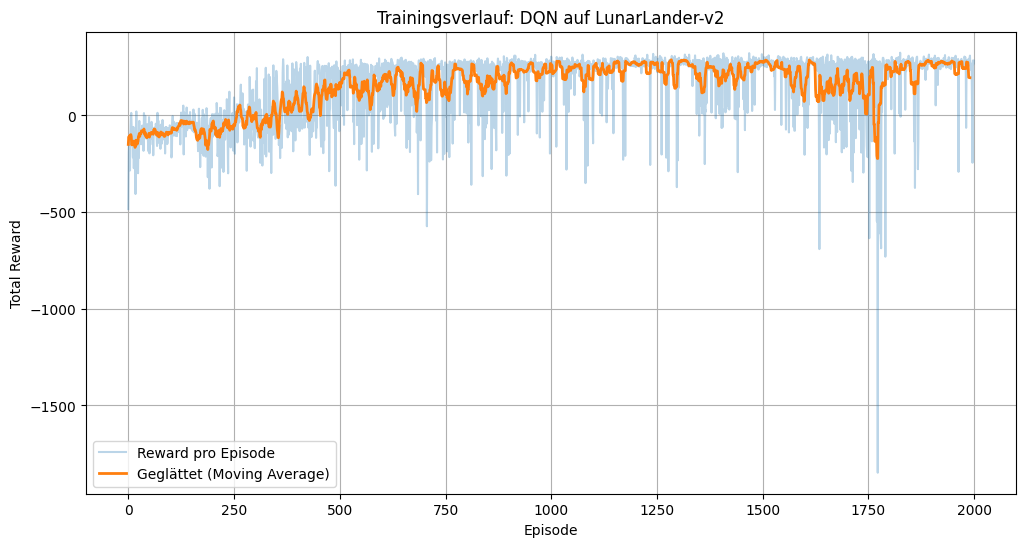

In [ ]:
# Visualisierung: Trainingsverlauf mit Original-Rewards und geglättetem Verlauf (Moving Average)

def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(12, 6))
plt.plot(rewards_per_episode, label="Reward pro Episode", alpha=0.3)
plt.plot(moving_average(rewards_per_episode), label="Geglättet (Moving Average)", linewidth=2)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Trainingsverlauf: DQN auf LunarLander-v2")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Evaluation: Modelltest auf 10 Episoden zur Bewertung der finalen Policy-Qualität

test_rewards = []
for episode in range(10):
    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        with torch.no_grad():
            action = policy_net(torch.FloatTensor(state)).argmax().item()
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward

    test_rewards.append(total_reward)

print(f"Durchschnittlicher Reward über 10 Testepisoden: {np.mean(test_rewards):.2f}")


Durchschnittlicher Reward über 10 Testepisoden: 226.39


In [ ]:
# Erstellung von GIF-Videos zur visuellen Darstellung einzelner Testepisoden mit dem trainierten Modell

import gym
import torch
import numpy as np
from PIL import Image
import os

# Ordner für Videos anlegen
os.makedirs("videos", exist_ok=True)

# Anzahl der Episoden
NUM_EPISODES = 5  # Du kannst das beliebig erhöhen

# LunarLander-Umgebung mit Bildausgabe
env = gym.make("LunarLander-v2", render_mode="rgb_array")

# Durchlauf mehrerer Episoden
for i in range(NUM_EPISODES):
    frames = []
    state, _ = env.reset(seed=i)
    done = False
    total_reward = 0

    while not done:
        # Bild speichern
        frame = env.render()
        frames.append(Image.fromarray(frame))

        # Aktion vom trainierten Modell wählen
        with torch.no_grad():
            action = policy_net(torch.FloatTensor(state)).argmax().item()

        # Umgebung weiterschalten
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward

    # Video speichern
    video_path = f"videos/lunarlander_episode_{i}_reward_{int(total_reward)}.gif"
    frames[0].save(
        video_path,
        save_all=True,
        append_images=frames[1:],
        duration=50,  # ms pro Frame
        loop=0,
        format="GIF"
    )

    print(f"🎬 Episode {i+1} gespeichert → {video_path} | Total Reward: {total_reward:.2f}")

env.close()


🎬 Episode 1 gespeichert → videos/lunarlander_episode_0_reward_292.gif | Total Reward: 292.90
🎬 Episode 2 gespeichert → videos/lunarlander_episode_1_reward_268.gif | Total Reward: 268.29
🎬 Episode 3 gespeichert → videos/lunarlander_episode_2_reward_225.gif | Total Reward: 225.56
🎬 Episode 4 gespeichert → videos/lunarlander_episode_3_reward_246.gif | Total Reward: 246.71
🎬 Episode 5 gespeichert → videos/lunarlander_episode_4_reward_1.gif | Total Reward: 1.93
